<div align="center">
    <img width="400em" src="logo_magnETHical.svg">
</div>

In this demo we will

1. setup the spectrometer, 
2. record a free induction decay (FID) and 
3. do some simple analysis.

To prevent any confusion we'll look at all the code, but glance over some parts more quickly.

## Imports
- First, some standard `imports` you might already be familiar with
- These make the imported `modules` / `classes` / `functions` available later
- The `%matplotlib widget` makes the graphs interactive


In [1]:
# Python imports
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import nmrglue as ng

# Standard science imports
import numpy as np

# Spectrometer imports
from spectrometer import (
    FID1D,
    ConnectionSettings,
    Delay,
    NMRSequence,
    Pulse,
    Record,
    Server,
    Spectrometer,
    plot,
    process,
)

%matplotlib widget

Did not find any configuration file. Using defaults.


## Setup 
### Prepare the hardware

The basic steps are:

1. Compiling and flashing the FPGA firmware
2. Setting up the `MaRCoS` server
3. Connecting to the server

In [2]:
# Setup the server
server = Server("192.168.1.100")

# Flash the FPGA bitstream (or "low level server")
server.flash_fpga()

# Compile the server on the spectrometer (or "high level server")
server.setup()

# Start the server on the spectrometer
server.start()

MaRCoS server is already running! Stopping server...


### Connect to the spectrometer server

Now that the server is running we can connect to it.

In [3]:
# Setup the spectrometer connection
connection_settings = ConnectionSettings(ip_address="192.168.1.100")

# Create the spectrometer object
spectrometer = Spectrometer(
    tx_freq=25_091_000,  # Center transmission frequency
    rx_freq=None,  # Receive frequency
    sample_rate=320_000,  # samples/second
    server_config=connection_settings,
)

# Connect to the spectrometer server
spectrometer.connect()

## Perform an experiment

Now we want to perform a simple experiment.

Here we'll send a single pulse and look at the received signal

 1. Prepare the pulse sequence
 2. Send the sequence and save the received signal
 3. Processing

### Preparing a pulse sequence
We have multiple options for defining sequences:

1. Use the simple built-in ones (`simple`, `spin_echo`)
2. Build our own from a list of instructions
3. Define the control arrays manually   

We'll define a pulse with

- 9us length
- 30us delay
- 10ms record

using all three methods.

In [4]:
seq_simple = NMRSequence.simple(pulse_length_us=9, delay_us=30, record_length_us=10_000)
# same as
seq_built = NMRSequence.build(
    [Pulse(duration_us=9, power=1), Delay(duration_us=30), Record(duration_us=10_000)]
)
# or
seq_manual = NMRSequence(
    tx_sequence=(np.array([0, 9]), np.array([1, 0])), rx_sequence=np.array([39, 10039])
)

assert seq_simple == seq_built == seq_manual

### Sending the pulse sequence

Since all the sequences are the same we can sent any of them

/home/mstabel/Projects/nmr-spectrometer/software/spectrometer/.venv/lib/python3.11/site-packages/marcos/server_comms.py:97: MarServerWarning: no RX data received
  warnings.warn(k, MarServerWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


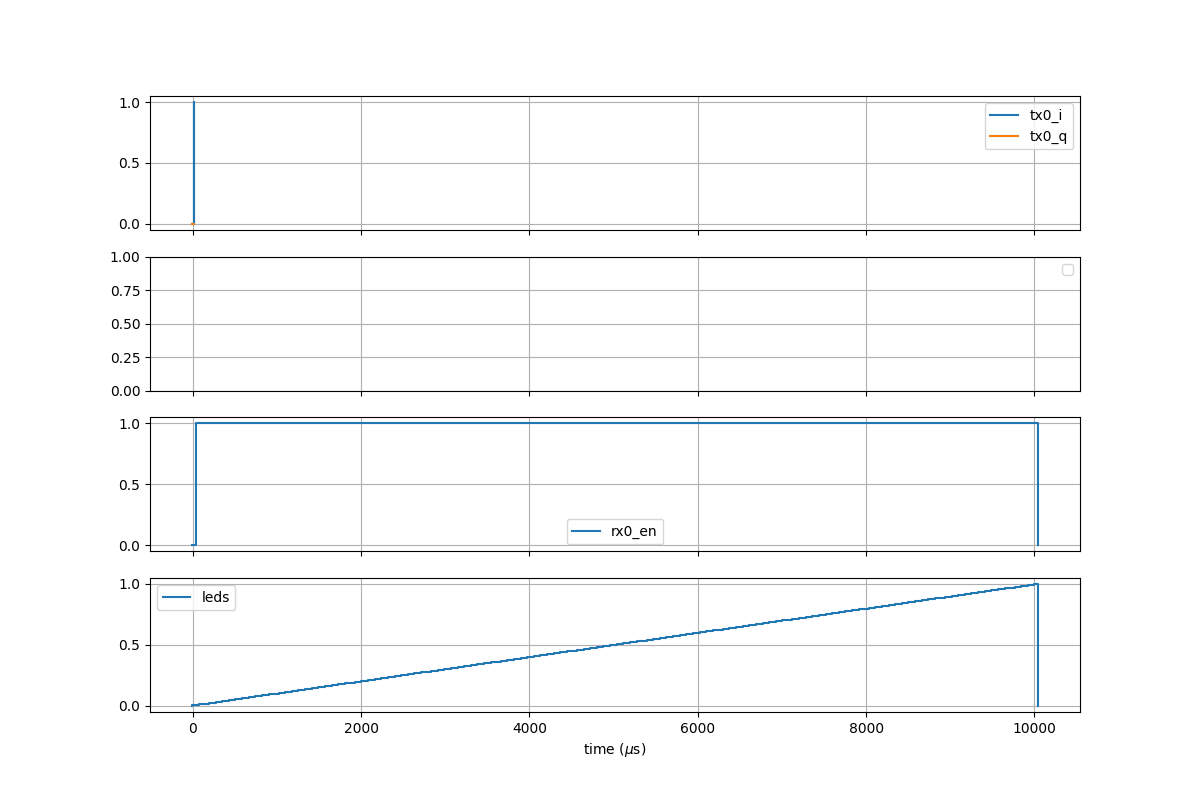

In [5]:
# Send the sequence
data = spectrometer.send_sequence(seq_simple, debug=True)

`data` contains the complex QI-demodulated data as a one dimensional `numpy` array.

Now we can put the data into a simple container with the relevant metadata and save it to a file for later processing.

In [6]:
# Create FID object
fid = FID1D(
    data=data,
    spectral_width=spectrometer.sample_rate,
    carrier_freq=0.0,
    observation_freq=spectrometer.rx_freq,
    label="1H",
    sample="Water",
    pulse="single_90_degree_pulse,length=9us,delay=30us",
    spectrometer="magnETHical v0.1",
)

# Save to file
time = fid.timestamp.strftime("%Y%m%d-%H%M%S")
file = Path(f"../../data/{time}-{fid.sample}-{fid.label}-{fid.pulse}.fid")
fid.to_file(file)

The data is stored in standard `nmrpipe` format, thus further analysis can be conducted in any other tooling capable of reading that format.

For more features and further information, see the various `record_*` and `process_` scripts in the `scripts` folder and the library reference.

In [7]:
# Stop the server
server.stop()

## Analyzing the received signal

Having conducted all of our experiments, we can load the data from file to analyze it. 

- outside of Python, e.g. in `NMRPipe`,
- in Python using e.g. `nmrglue`, `numpy`, `scipy`, `matplotlib`, ... or
- any tooling that can read `NMRPipe` `.fid` files

### Loading the data back into Python

We'll now quickly look at the data with some small helper functions built around `nmrglue`

In [8]:
# Load data back from file
fid = FID1D.from_file(file)

### Plot the data

Now we can plot the time domain data

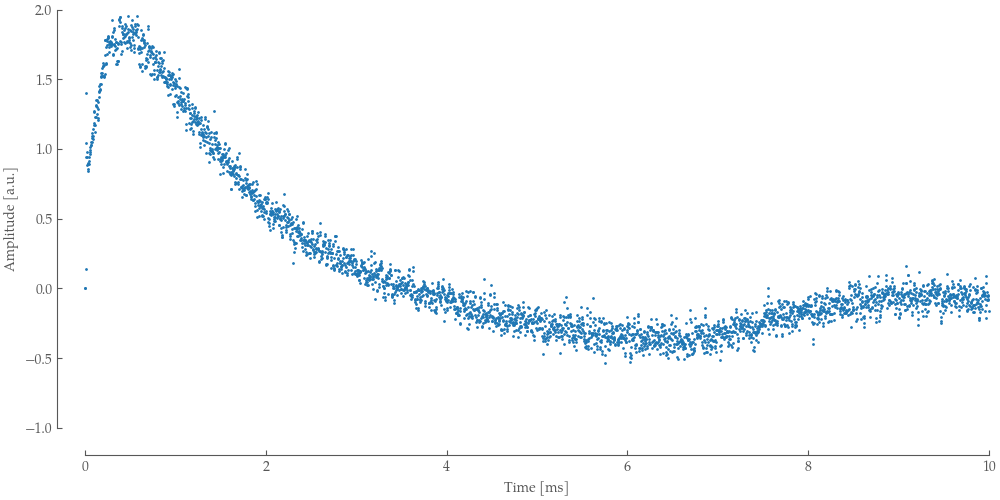

In [9]:
# Take a quick look at the time domain data (i.e. the FID)
fig = fid.plot()

In [12]:
# Try to plot simple least squares fit for a decaying sinusoid
decaying_sinus = process.decaying_sinus.fit(fid.ms_scale, fid.data.real)
ms_scale_fine = np.linspace(fid.ms_scale[0], fid.ms_scale[-1], len(fid.ms_scale) * 10)
print(decaying_sinus)

# Plot raw values again
fig = fid.plot()

# Plot fit
fig.axes[0].plot(
    ms_scale_fine,
    decaying_sinus(ms_scale_fine),
    linestyle="--",
)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.

There's also a function to quickly get a simple spectrum.

This function does by default
- zero-fill
- complex fft
- simple automatic phase correction
    - by minimizing the difference of minima around the highest maximum

Zero-order phase correction: -20.32002343750002


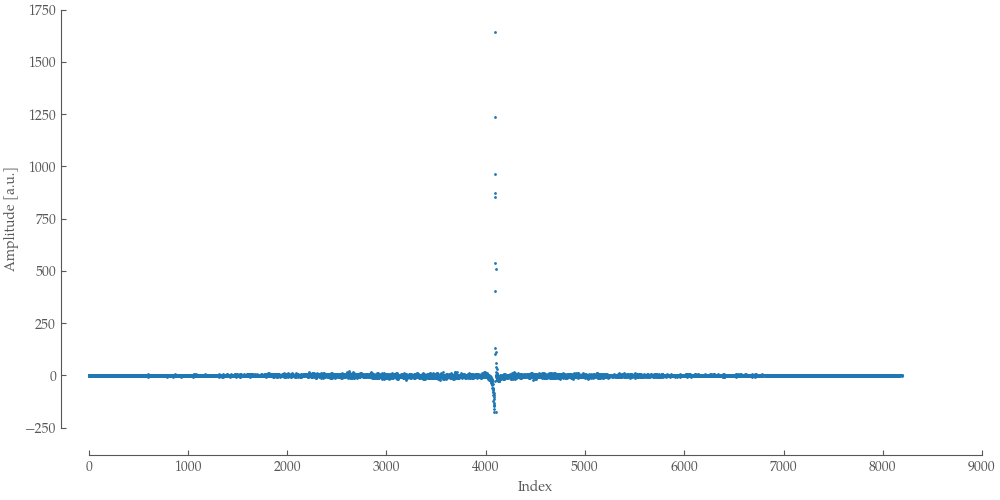

In [38]:
# Take a quick look at the spectrum
# (includes an auto zero-fill, complex fft and simple auto phase correction)
spectrum, p0 = fid.spectrum()
print("Zero-order phase correction:", p0)

fig = spectrum.plot()

We could - for example - crop the data a bit 

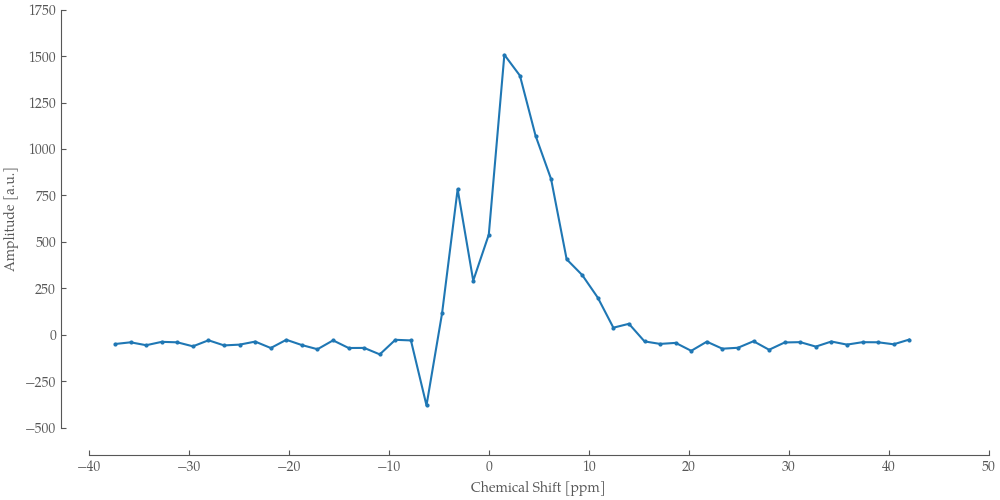

In [45]:
# FFT again cause we can
# We can also manually specify the zero-order phase shift by passing `phase_shift_kwargs={"p0": 68}`
spectrum, _ = fid.spectrum(phase_shift_kwargs={"p0": p0+20})

# Crop
cropped_spectrum = spectrum.hz.crop_around(spectrum.hz.max_peak, 2000)
fig = cropped_spectrum.ppm.plot(linestyle="-")

### Do a fit

Now we can take the peak and try to do a Lorentz fit to get some interesting paramters:

- amplitude
- position
- peak width (gamma)

Requested font Merriweather Sans doesn't exist! Using defaults.


Amplitude: 2569.5330041195657
Gamma: 108.77030994297714 Hz
Position: -155.62113946026432 Hz


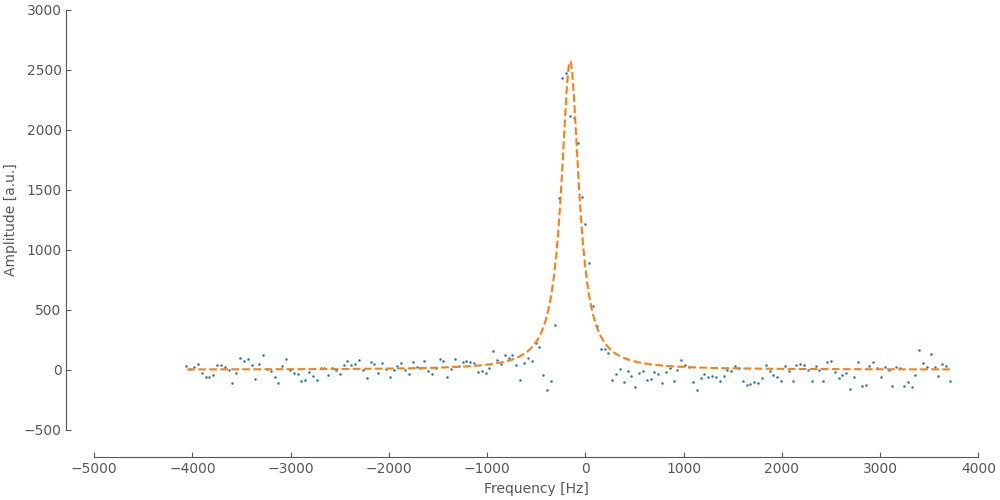

/home/mstabel/Projects/nmr-spectrometer/software/spectrometer/.venv/lib/python3.11/site-packages/ipympl/backend_nbagg.py:279: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  self.manager.handle_json(content)


In [ ]:
# Try to plot simple least squares fit for a lorentzian peak
decaying_sinus = process.fit_lorentz(peak_hz_scale, peak_fft_vals.real)
ms_scale_fine = np.linspace(
    peak_hz_scale[0], peak_hz_scale[-1], len(peak_hz_scale) * 10
)

print(f"Amplitude: {decaying_sinus['amplitude']}")
print(f"Gamma: {decaying_sinus['gamma']} Hz")
print(f"Position: {decaying_sinus['position']} Hz")

# Plot manually
fig, axes = plot.subplots(figsize=(10, 5))
axes.set_ylabel("Amplitude [a.u.]")
axes.set_xlabel("Frequency [Hz]")

# Plot raw values again
axes.plot(
    peak_hz_scale,
    peak_fft_vals.real,
    linestyle="",
    marker="o",
    markersize=2,
)

# Plot fit
axes.plot(
    ms_scale_fine,
    decaying_sinus["function"](ms_scale_fine),
    linestyle="--",
)

plot.format_axes(axes, font="Merriweather Sans")